Relax


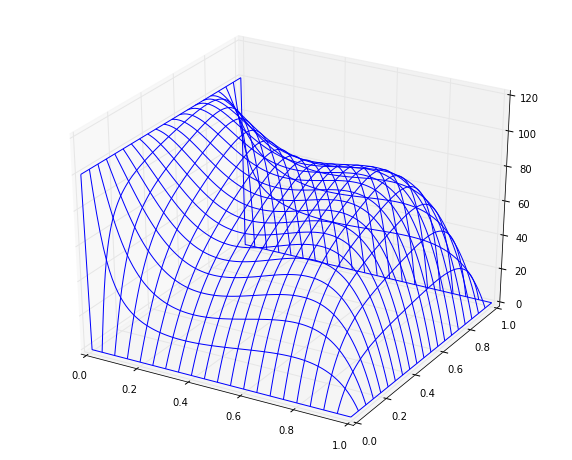

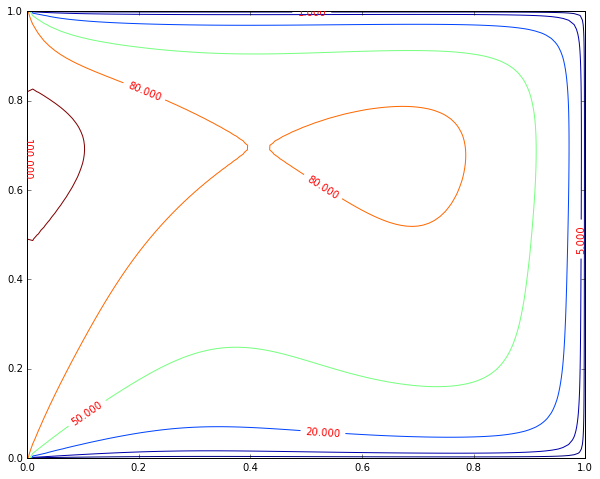

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
%matplotlib inline

class Pois_solver:
    def __init__(self, A, step, U, N, method, omega = 1, epsilon = .8): #A - размер сетки, N - число итераций, omega - параметр релаксации;
        #'J' - Якоби, 'G' - Гаусс, 'R' - релаксация
        self.A = A
        self.step = step
        self.N = N
        self.Nknots = int(A/step + 1)
        self.U = U
        self.method = method
        self.omega = omega
        self.epsilon = epsilon

    def trace(self):
        return np.abs(self.U.reshape(self.Nknots**2)[::self.Nknots + 1]).sum()
   
    def jacobi(self, n):
        tr = 0.
        for i in range(n):
            if (i % 100 == 0): #будем проверять разность норм каждые 100 шагов
                tr = self.trace()
            
            safe_first_string = self.U[0]
            safe_last_string = self.U[self.Nknots - 1]
            safe_first_column = self.U[:,0]
            safe_last_column = self.U[:,self.Nknots - 1]
            
            self.U = (np.roll(self.U, 1, 0) + np.roll(self.U, -1, 0) + np.roll(self.U, 1, 1) + np.roll(self.U, -1, 1))/4.
            
            #восстанавливаем граничные значния (roll их нарушил)
            self.U[self.Nknots - 1] = safe_last_string
            self.U[0] = safe_first_string 
            self.U[:,0] = safe_first_column
            self.U[:,self.Nknots - 1] = safe_last_column 
            
            if (i % 100 == 0 and abs(tr - self.trace()) < self.epsilon):
                print 'Breaked at i = ', i
                break
             
    def relax(self, n): #на основе jacobi
        
        greed = np.empty((self.Nknots,self.Nknots), [('x',np.float64), ('y',np.float64)])
        greed['x'], greed['y'] = np.meshgrid(np.linspace(0, self.A, self.Nknots),\
                                                       np.linspace(0, self.A, self.Nknots))
        
        tr = 0.
        print 'Relax'
        for i in range(n):
            if (i % 100 == 0): #будем проверять разность норм каждые 100 шагов
                tr = self.trace()
            
            safe_first_string = self.U[0]
            safe_last_string = self.U[self.Nknots - 1]
            safe_first_column = self.U[:,0]
            safe_last_column = self.U[:,self.Nknots - 1]
            
            self.U = (np.roll(self.U, 1, 0) + np.roll(self.U, -1, 0) + np.roll(self.U, 1, 1) + np.roll(self.U, -1, 1))/4.\
                    + 0.1*np.sqrt(greed['x']**2 + greed['y']**2)
            
            #восстанавливаем граничные значния (roll их нарушил)
            self.U[self.Nknots - 1] = safe_last_string
            self.U[0] = safe_first_string 
            self.U[:,0] = safe_first_column
            self.U[:,self.Nknots - 1] = safe_last_column 
            
            if (i % 100 == 0 and abs(tr - self.trace()) < self.epsilon):
                print 'Breaked at i = ', i
                break
           
    
    def gauss(self, N):
        for n in range(N):
            if (n % 100 == 0): #будем проверять разность норм каждые 100 шагов
                tr = self.trace()
            for i in range(1, self.Nknots - 1):
                for j in range(1, self.Nknots - 1):
                    self.U[i][j] = (self.U[i-1][j] + self.U[i+1][j] + self.U[i][j-1] + self.U[i][j+1])/4.
            if (n % 100 == 0 and abs(tr - self.trace()) < self.epsilon):
                print 'Breaked at n = ', n
                break
    
    def evolution(self, n):
        if self.method == 'J':
            self.jacobi(n)
            
        if self.method == 'G':
            self.gauss(n)
            
        if self.method == 'R':
            self.relax(n)
        
    def show_plot(self):
        greed = np.empty((self.Nknots,self.Nknots), [('x',np.float64), ('y',np.float64)])
        greed['x'], greed['y'] = np.meshgrid(np.linspace(0, self.A, self.Nknots),\
                                                       np.linspace(0, self.A, self.Nknots))
        fig = plt.figure(figsize=(10,8))
        ax = fig.add_subplot(111, projection='3d')
        ax.plot_wireframe(greed['x'], greed['y'], self.U, rstride=5, cstride=5)
        
    def show_contour(self):
        greed = np.empty((self.Nknots,self.Nknots), [('x',np.float64), ('y',np.float64)])
        greed['x'], greed['y'] = np.meshgrid(np.linspace(0, self.A, self.Nknots),\
                                                       np.linspace(0, self.A, self.Nknots))
        
        fig = plt.figure(figsize=(10,8))
        CS = plt.contour(greed['x'], greed['y'], self.U, locator=plt.FixedLocator((1, 5, 20, 50, 80, 100)))
        plt.clabel(CS, inline=1, fontsize=10, colors='red')

        
    def run(self, snapshots):
        n = 0
        for n1 in snapshots:
            n = n1 - n
            self.evolution(n)
            self.show_plot()
            #self.show_contour()
        
        self.show_contour()

A = 1.
step = .01
N = 1000
V = 100
Nknots = int(A/step + 1)

U = np.zeros(shape = (Nknots, Nknots))
U[:,0] = V
snapshots = [1000]

P = Pois_solver(A, step, U, N, 'R')
P.run(snapshots)